### Numerical Model for Ocean Flow
Sierra Stevenson under mentorship of Dr. Marcelo Chamecki

We are solving the system of equations

$$
\begin{cases}

\frac{\partial{\bar{u}}}{\partial{t}} &= f(\bar{v} - v_g) + \frac{\partial{k}}{\partial{z}}  \frac{\partial{\bar{u}}}{\partial{z}} + k \frac{\partial{^2\bar{u}}}{\partial{z^2}} 
\\
\frac{\partial{\bar{v}}}{\partial{t}} &= f(\bar{u} - u_g) + \frac{\partial{k}}{\partial{z}}  \frac{\partial{\bar{v}}}{\partial{z}} + k \frac{\partial{^2\bar{v}}}{\partial{z^2}}

\end{cases}
$$

with boundary conditions

*surface ($z=0$):*  $k \frac{\partial{\bar{u}}}{\partial{z}} = \frac{T_x}{\rho}$,  $k \frac{\partial{\bar{v}}}{\partial{z}} = \frac{T_y}{\rho}$

*bottom ($z=-\infty$):* $\bar{u} = u_g, \bar{v} = v_g$


Knowing $u_g, v_g, k(z),$ and $f$, we want to find $\bar{u}{z}$ and $\bar{v}{z}$.<br>Solution verified for $k = const.$, now implementing variable $k$.
<p>

We are using a simple explicit time and space discretization (see notes) with ghost nodes above the surface.

# Code

Import libraries

In [114]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

from mpl_toolkits import mplot3d
from matplotlib import animation
from IPython.display import HTML

# Font style for plotting
plt.rcParams["font.family"] = "Georgia"
plt.rcParams["font.size"] = 10

In [115]:
# Create dataframe of LES runs data
LES_runs = pd.read_csv("C:/Users/Sierra/Desktop/Chamecki Lab/LES_runs/all_LES_runs(1).txt", sep=None, engine="python")
LES_runs = LES_runs.rename({"A" : "Lambda"}, axis = 1)
file_names = ["wu00L02","wu00L03","wu00L10","wu00Lin","wu00L04","wu01L03","wu01Lin","wu01L10","wu02L04","wu03L20","wu10L09","wu20L03","wu0inLna"]
fn = len(file_names)
path = "C:/Users/Sierra/Desktop/Chamecki Lab/LES_runs/"
files = LES_runs["File"].values

df = {}
for file, file_name in zip(files, file_names):
        df[file_name] = pd.read_csv(path + file)

### Set variable values for base case

We will copy the standard model for the Ekman spiral to test against.

In [116]:
# Constants
f = 7 * 10 ** (-5)      # /s; Coriolis parameter
tau_x_over_rho = 1 * 10 ** (-4)  # m/s; wind stress (tau_x / rho)
tau_y_over_rho = 0               # m/s; wind stress (tau_y / rho)

ug = 0                  # Geostrophic velocity
vg = 0                  # Geostrophic velocity

# Space
Z = 100              # Depth (m)
dz = 1             # Step in depth z
Nz = int(Z/dz)            # Number of nodes (100 nodes + 1 ghost node at top and bottom)
z = np.arange(1,-Z+1,-dz) # Space range (-Nz-0)

# Time
T = 100000           # Time elapsed (s)
dt = 15              # Step in time t
Nt = int(T * dt)    # Number of time steps
t = np.arange(Nt)   # Time range (0-Nt)

hours = T / 60 / 60
print("hours = ", round(hours,2))

# Eddy diffusivity
K = np.ones(Nz) * 10 ** (-2)          # m^2/s; eddy diffusivity


# Stability
S = ( np.mean(K) * dt) / (dz ** 2)  # Von Neumann number (stability)
print("Von Neumann number:", round(S,2))

omega = 10 ** -4    # Ambient rotation rate at midlats (/s)

hours =  27.78
Von Neumann number: 0.15


In [117]:
# Ekman spiral as known
d = np.sqrt(2 * K / f)
us = ug + (np.sqrt(2) / (f * d) * np.exp(z/d)) * (tau_x_over_rho * np.cos(z / d - np.pi / 4 ) - tau_y_over_rho * np.sin(z/d - np.pi / 4))
vs = vg + (np.sqrt(2) / (f * d) * np.exp(z/d)) * (tau_x_over_rho * np.sin(z / d - np.pi / 4 ) + tau_y_over_rho * np.cos(z/d - np.pi / 4))

### Initialize arrays

In [118]:
u = np.zeros(Nz)
v = np.zeros(Nz)
u_saved = np.zeros((Nz, int(Nt//dt)))
v_saved = np.zeros((Nz, int(Nt//dt)))

Eddy diffusivity

Main loop

In [119]:
dKdz = np.zeros(Nz)

In [120]:
for n in np.arange(0, Nt - 1, dt):  # Loop thru time

    # Initialize arrays for next time step
    u_1 = np.zeros(Nz)
    v_1 = np.zeros(Nz)
    u_2 = np.zeros(Nz)
    v_2 = np.zeros(Nz)
    u_fut = np.zeros(Nz)
    v_fut = np.zeros(Nz)

    # Boundary condition
    u[0] = u[2] + (2 * dz * tau_x_over_rho) / K[1]
    v[0] = v[2] + (2 * dz * tau_y_over_rho) / K[1]

    for i in range(1, Nz-1): # Loop thru space
        dKdz[i] = 0
        u_1[i] = u[i] + (dt/3) * ((f * (v[i] - vg) + (K[i] / dz ** 2) * (u[i+1] - 2 * u[i] + u[i-1])) + dKdz[i] * (u[i+1] - u[i-1])/(2*dz) )
        v_1[i] = v[i] + (dt/3) * ( (-f * (u[i] - ug) + (K[i] / dz ** 2) * (v[i+1] - 2 * v[i] + v[i-1])) + (dKdz[i]) * (v[i+1] - v[i-1])/(2*dz) )
        
    # BC
    u_1[0] = u_1[2] + (2 * dz * tau_x_over_rho) / K[1]
    v_1[0] = v_1[2] + (2 * dz * tau_y_over_rho) / K[1]
    u_1[-1] = ug
    v_1[-1] = vg


    for i in range(1, Nz-1): # Loop thru space
        u_2[i] = u[i] + (dt/2) * (  (f * (v_1[i] - vg) + (K[i] / dz ** 2) * (u_1[i+1] - 2 * u_1[i] + u_1[i-1])) + (dKdz[i]) * (u_1[i+1] - u_1[i-1])/(2*dz) )
        v_2[i] = v[i] + (dt/2) * ( (-f * (u_1[i] - ug) + (K[i] / dz ** 2) * (v_1[i+1] - 2 * v_1[i] + v_1[i-1])) + (dKdz[i]) * (v_1[i+1] - v_1[i-1])/(2*dz) )
        
    # BC
    u_2[0] = u_2[2] + (2 * dz * tau_x_over_rho) / K[1]
    v_2[0] = v_2[2] + (2 * dz * tau_y_over_rho) / K[1]
    u_2[-1] = ug
    v_2[-1] = vg

    for i in range(1, Nz-1): # Loop thru space
        u_fut[i] = u[i] + (dt) * (  (f * (v_2[i] - vg) + (K[i] / dz ** 2) * (u_2[i+1] - 2 * u_2[i] + u_2[i-1])) + (dKdz[i]) * (u_2[i+1] - u_2[i-1])/(2*dz) )
        v_fut[i] = v[i] + (dt) * ( (-f * (u_2[i] - ug) + (K[i] / dz ** 2) * (v_2[i+1] - 2 * v_2[i] + v_2[i-1])) + (dKdz[i]) * (v_2[i+1] - v_2[i-1])/(2*dz) )
    
    # Boundary conditions
    u_fut[-1] = ug
    v_fut[-1] = vg
    
    u = np.copy(u_fut)
    v = np.copy(v_fut)

    # Save history
    if n%dt == 0:
        u_saved[:,int(n//dt)] = np.copy(u_fut)
        v_saved[:,int(n//dt)] = np.copy(v_fut)

In [121]:
# Get average value of u and v oscillations, should be period 2pi/f
u_avg = np.mean(u_saved[:,int(2*np.pi/f):], axis=1)
v_avg = np.mean(v_saved[:,int(2*np.pi/f):], axis=1)

Plot

$u$ vs. $v$

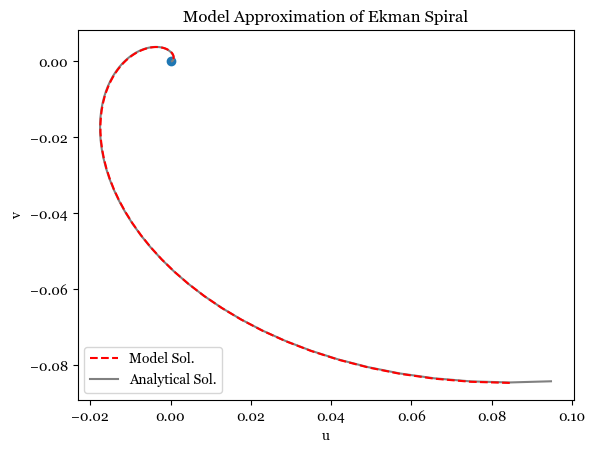

In [122]:
# Plot avg'd model solution
plt.plot(u_avg[1:], v_avg[1:], color='red', zorder=3, label="Model Sol.", ls="--")

# Analytical plot
plt.plot(us, vs, color='gray', linestyle='-', label="Analytical Sol.")

# LES run plot
# u_PWS, v_PWS = df["wu00Lin"]["u"], df["wu00Lin"]["v"]
# plt.plot(u_PWS, v_PWS, color="darkblue", label="PWS velocity profile")

# Plot labels
# plt.axhline(0)
plt.scatter(0,0)
plt.xlabel("u")
plt.ylabel("v")
plt.title("Model Approximation of Ekman Spiral")
plt.legend(loc="lower left")
plt.show()

$u$ and $v$ depth profiles

In [123]:
len(u_avg)
len(z)

100

In [142]:
z

array([  1,   0,  -1,  -2,  -3,  -4,  -5,  -6,  -7,  -8,  -9, -10, -11,
       -12, -13, -14, -15, -16, -17, -18, -19, -20, -21, -22, -23, -24,
       -25, -26, -27, -28, -29, -30, -31, -32, -33, -34, -35, -36, -37,
       -38, -39, -40, -41, -42, -43, -44, -45, -46, -47, -48, -49, -50,
       -51, -52, -53, -54, -55, -56, -57, -58, -59, -60, -61, -62, -63,
       -64, -65, -66, -67, -68, -69, -70, -71, -72, -73, -74, -75, -76,
       -77, -78, -79, -80, -81, -82, -83, -84, -85, -86, -87, -88, -89,
       -90, -91, -92, -93, -94, -95, -96, -97, -98])

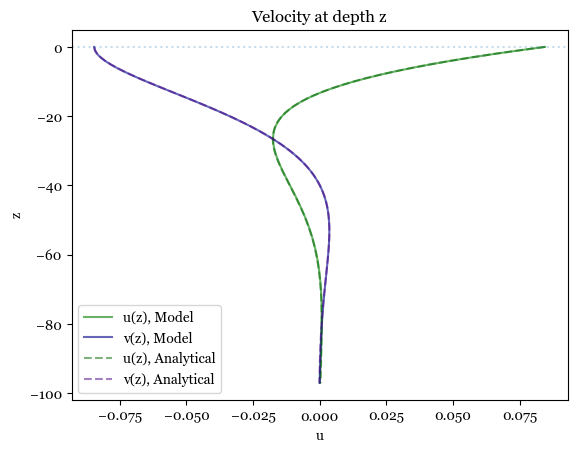

In [141]:
# Model plot
a = 1
b = -1

plt.plot(u_avg[a:b], z[a:b], alpha=0.6, label="u(z), Model", color="green")
plt.plot(v_avg[a:b], z[a:b], alpha=0.6, label="v(z), Model", color="darkblue")

# Analytical plot
plt.plot(us[a:b], z[a:b], label="u(z), Analytical", color="darkgreen", alpha=0.5, linestyle="--")
plt.plot(vs[a:b], z[a:b], label="v(z), Analytical", color="indigo", alpha=0.5, linestyle="--")

# Plot labels
plt.axhline(0, ls=":", alpha=0.25)
plt.xlabel("u")
plt.ylabel("z")
plt.title("Velocity at depth z")
plt.legend()
plt.show()

Time evolution of ($u_1, v_1$)

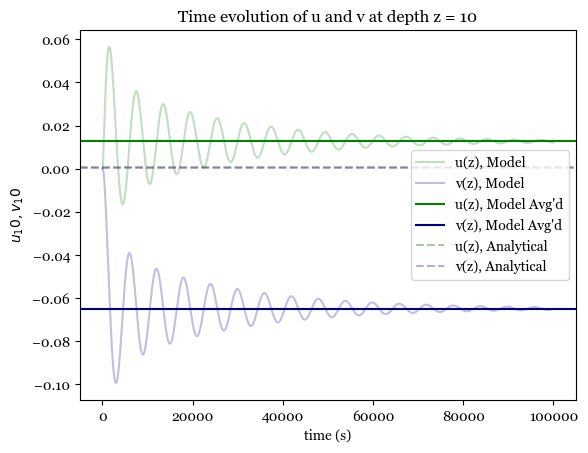

In [126]:
def PlotTimeEvolutionAt(depth):
    # Model plot
    plt.plot(u_saved[depth+1,2:-1], label="u(z), Model", color="green", alpha=0.25)
    plt.plot(v_saved[depth+1,2:-1], label="v(z), Model", color="darkblue", alpha=0.25)

    plt.axhline(u_avg[depth+1], label="u(z), Model Avg'd", color="green")
    plt.axhline(v_avg[depth+1], label="v(z), Model Avg'd", color="darkblue")

    # Analytical plot
    plt.axhline(us[-depth], label="u(z), Analytical", color="darkgreen", alpha=0.35, linestyle="--")
    plt.axhline(vs[-depth], label="v(z), Analytical", color="indigo", alpha=0.35, linestyle="--")

    # Plot labels
    plt.xlabel("time (s)")
    plt.ylabel(f"$u_{depth}, v_{depth}$")
    plt.title(f"Time evolution of u and v at depth z = {depth}")
    plt.legend()
    plt.show()

# PlotTimeEvolutionAt(1)
PlotTimeEvolutionAt(10)
# PlotTimeEvolutionAt(30)
# PlotTimeEvolutionAt(50)
# PlotTimeEvolutionAt(80)

In [127]:
# # Model plot
# plt.plot(u_saved[5,1:-2], label="u(z), Model", color="green", ls='--')
# plt.plot(v_saved[5,1:-2], label="v(z), Model", color="darkblue", ls='--')

# # Analytical plot
# plt.axhline(us[-5+1], label="u(z), Analytical", color="darkgreen", alpha=0.35, linestyle="-", zorder=3)
# plt.axhline(vs[-5+1], label="v(z), Analytical", color="indigo", alpha=0.35, linestyle="-", zorder=3)

# # Model plot, avgd
# plt.axhline(u_avg[5], c="red", zorder=9, ls=':', alpha=0.5)
# plt.axhline(v_avg[5], c="red", zorder=9, ls=':', alpha=0.5)


# # Plot labels
# plt.xlabel("time (s)")
# plt.ylabel(f"$u, v$")
# plt.legend()
# plt.show()